In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple, defaultdict
from itertools import count
from tqdm import tqdm_notebook

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/Users/anton.kuryshov/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


Добавим в среду TicTacToe метод step_against_random

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}
    
    def step_against_random(self, action):
        (next_state, empty_spaces, cur_turn), reward, done, _ = env.step(action)
        if done:
            return (next_state, empty_spaces, cur_turn), reward, done, _
        action = np.random.randint(len(empty_spaces))
        action = empty_spaces[action]
        return env.step(action)

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [3]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )

    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [4]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

In [5]:
# N_ROWS, N_COLS, N_WIN = 3, 3, 3

env = TicTacToe()

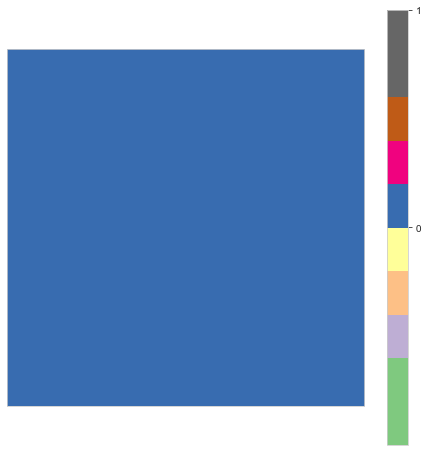

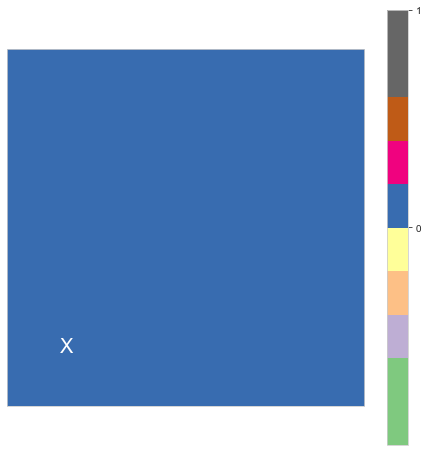

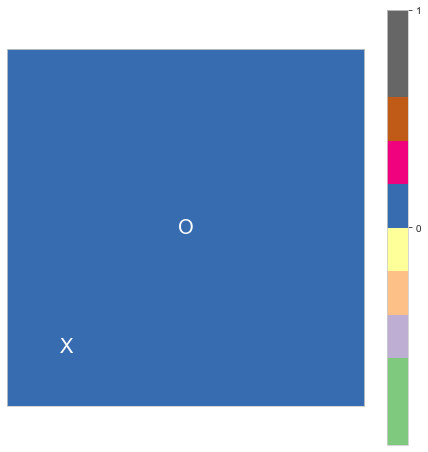

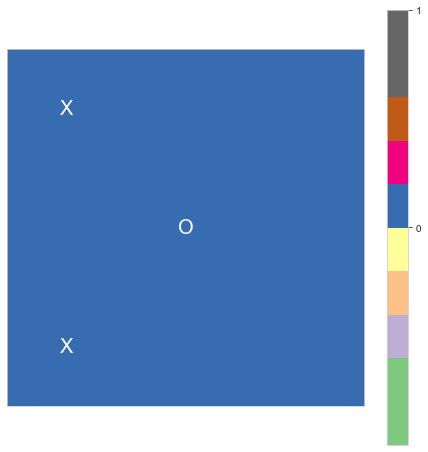

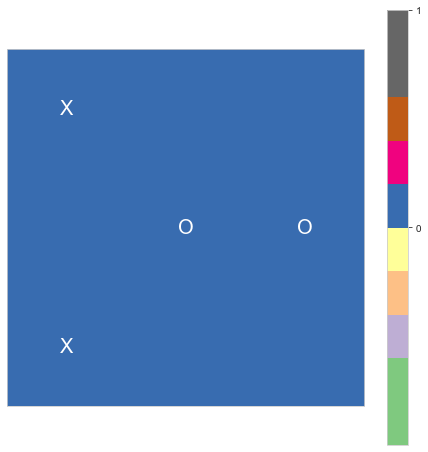

Крестики выиграли!


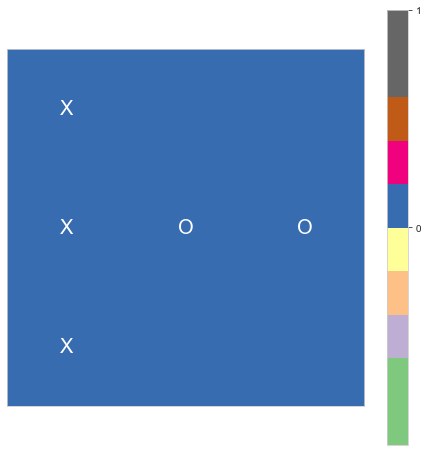

In [19]:
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, 
               verbose=True, fontx=20)

### Часть первая: крестики-нолики при помощи Q-обучения

In [6]:
class Qlearning:
    def __init__(self, env, alpha=0.4, gamma=1, min_epsilon=0.01):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.min_epsilon = min_epsilon
        self.Q = defaultdict(lambda: [0] * (env.n_rows * env.n_cols))
        
        
    def reset_all(self):
        self.Q = defaultdict(lambda: [0] * (self.env.n_rows * self.env.n_cols))
        self.env.reset()
    
    def get_action(self, state, empty_spaces, eps=0):
        if len(empty_spaces) == 0:
            return -1
        empty_spaces = [self.env.n_cols * i[0] + i[1] for i in empty_spaces]
        if np.random.rand() > eps:
            action = np.argmax(np.take(self.Q[state], empty_spaces))
            action = empty_spaces[action]
        else:
            action = np.random.choice(empty_spaces)
        return action
    
    def update_Q(self, state, next_state, action, reward, done):
        gamma = self.gamma
        if done:
            gamma = 0
        next_action = self.get_action(next_state, env.emptySpaces)

        self.Q[state][action] = self.Q[state][action] + self.alpha * (reward + gamma * self.Q[next_state][next_action] - self.Q[state][action])
        
    def conduct_experiments(self, iterations=10 ** 4):
        Rs = []
        for i in range(iterations):
            self.env.reset()
            state = self.env.getHash()
            empty_spaces = [[i, j] for i in range(self.env.n_rows) for j in range(self.env.n_cols)]
            done = False
            while not done:
                action = self.get_action(state, empty_spaces)
                pack = env.step_against_random(self.env.action_from_int(action))
                (next_state, empty_spaces, cur_turn), reward, done, _ = pack
                state = next_state
            Rs.append(reward)
        return np.mean(Rs)
    
    def train(self, num_episodes=2 * 10 ** 4):
        self.reset_all()
        Rs = []
        for i in tqdm_notebook(range(num_episodes)):
            if not i % 1000:
                Rs.append(self.conduct_experiments())
            self.env.reset()
            state = self.env.getHash()
            empty_spaces = [[i, j] for i in range(self.env.n_rows) for j in range(self.env.n_cols)]
            done = False
            while not done:
                eps = max(self.min_epsilon, 1 / (i + 1) ** 0.99)
                action = self.get_action(state, empty_spaces, eps)
                pack = self.env.step_against_random(self.env.action_from_int(action))
                (next_state, empty_spaces, cur_turn), reward, done, _ = pack
                self.update_Q(state, next_state, action, reward, done)
                state = next_state
                
        return Rs


In [7]:
q_learning = Qlearning(env, min_epsilon=0.01)

In [8]:
Rs = q_learning.train()

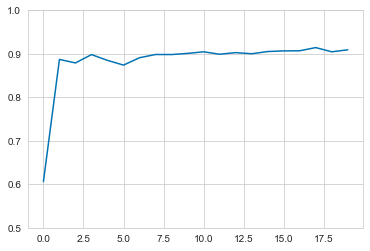

In [9]:
plt.ylim(0.5, 1)
plt.plot(Rs)

Попробуем тоже самое для доски 10x10. Чтобы выиграть надо собрать 5 крестиков.

In [10]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
q_learning = Qlearning(env, min_epsilon=0.01)

In [11]:
Rs = q_learning.train(20_000)

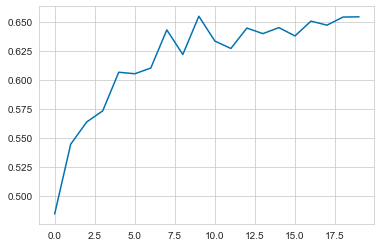

In [12]:
plt.plot(Rs)

Рост есть. Это радует. Кстати, 5х5 пробовал, не пошло.

### Часть вторая: добавим нейронных сетей

In [109]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
class Network(nn.Module):
    def __init__(self, n_cols, n_rows):
        nn.Module.__init__(self)
        self.conv_out_size = 9 # 5
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.conv = nn.Conv2d(1, self.conv_out_size, kernel_size=3, stride=1, padding=1)
        self.l2 = nn.Linear(self.conv_out_size * n_cols * n_rows, n_cols * n_rows)

    def forward(self, x):
        x = x.view(-1, 1, self.n_cols, self.n_rows)
        x = F.relu(self.conv(x))
        x = x.view(-1, self.conv_out_size * self.n_cols * self.n_rows)
        x = self.l2(x)
        return x

class TicTacToeDQN():
    def __init__(self, env):
        self.env = env
        self.model = Network(self.env.n_cols, self.env.n_rows)
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.steps_done = 0
        self.episode_durations = []
        
        self.gamma = 0.8
        self.batch_size = 64
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0
        
        self.mean_rewards = []

    def select_greedy_action(self, state, empty_spaces):
        state = state.flatten()
        sorted_actions = self.model(state).data.argsort().numpy().reshape(-1,1)
        for a in reversed(sorted_actions):
            if a not in empty_spaces:
                continue
            return self.env.action_from_int(a)
        assert 1 == 0, "something went wrong"
    
    def select_action(self, state):
        empty_spaces = self.env.emptySpaces
        if empty_spaces is None:
            empty_spaces = [[i, j] for i in range(self.env.n_rows) for j in range(self.env.n_cols)]
        if len(empty_spaces) == 0:
                return -1
        empty_spaces = [self.env.n_cols * i[0] + i[1] for i in empty_spaces]
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if np.random.rand() > eps_threshold:
            action = self.select_greedy_action(state, empty_spaces)
            action = action[0] * self.env.n_rows + action[1]
        else:
            action = np.random.choice(empty_spaces)
        return torch.tensor([[action]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False, render=False):
        self.env.reset()
        state, num_step = self.env.board.flatten(), 0
        empty_spaces = [[i, j] for i in range(self.env.n_rows) for j in range(self.env.n_cols)]
        while True:

            state_tensor = torch.tensor([state], dtype=torch.float32)
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state_tensor, empty_spaces)
                else:
                    action = self.select_action(state_tensor)
            action_tuple = self.env.action_from_int(action.numpy()[0][0])
            _, reward, done, _ = self.env.step_against_random(action_tuple)

            next_state = self.env.board.flatten()
            next_state_tensor = torch.tensor([next_state], dtype=torch.float32)

            transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            self.memory.store(transition)

            if do_learning:
                self.learn()

            state = next_state
            num_step += 1

            if done:
                self.episode_durations.append(num_step)
                break

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q
        
        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def play_one_game(self):
        self.model.eval()
        
        self.env.reset()
        state, num_step = self.env.board.flatten(), 0
        empty_spaces = [[i, j] for i in range(self.env.n_rows) for j in range(self.env.n_cols)]
        empty_spaces = [self.env.n_cols * i[0] + i[1] for i in empty_spaces]
        while True:

            state_tensor = torch.tensor([state], dtype=torch.float32)
    
            action_tuple = self.select_greedy_action(state_tensor, empty_spaces)
        
            _, reward, done, _ = self.env.step_against_random(action_tuple)
            next_state = self.env.board.flatten()
            next_state_tensor = torch.tensor([next_state], dtype=torch.float32)

            state = next_state
            num_step += 1
            empty_spaces = self.env.emptySpaces
            empty_spaces = [self.env.n_cols * i[0] + i[1] for i in empty_spaces]
            if done:
                break


        return reward
    def conduct_experiments(self, num_episodes=1000):
        Rs = []
        for i in range(num_episodes):
            Rs.append(self.play_one_game())
        self.mean_rewards.append(np.mean(Rs))


In [115]:
env = TicTacToe(8,8,5)
dqn = TicTacToeDQN(env)

for e in tqdm_notebook(range(300)):
    dqn.run_episode(e)
    dqn.conduct_experiments(1000)

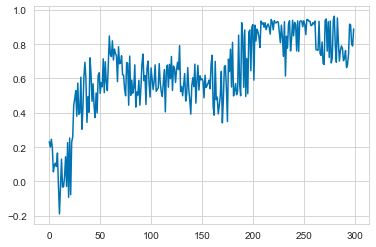

In [116]:
plt.plot(dqn.mean_rewards)

нормально стало получаться, когда каналов добавил у свертки

Делаем dueling DQN

In [146]:
class TicTacToeDQN():
    def __init__(self, env, adversary=None):
        self.env = env
        self.model = Network(self.env.n_cols, self.env.n_rows)
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.steps_done = 0
        self.episode_durations = []
        
        self.gamma = 0.8
        self.batch_size = 64
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0
        
        self.mean_rewards = []
        
        self.adversary = adversary

    def select_greedy_action(self, state, empty_spaces):
        state = state.flatten()
        sorted_actions = self.model(state).data.argsort().numpy().reshape(-1,1)
        for a in reversed(sorted_actions):
            if a not in empty_spaces:
                continue
            return self.env.action_from_int(a)
        assert 1 == 0, "something went wrong"
    
    def select_action(self, state):
        empty_spaces = self.env.emptySpaces
        if empty_spaces is None:
            empty_spaces = [[i, j] for i in range(self.env.n_rows) for j in range(self.env.n_cols)]
        if len(empty_spaces) == 0:
                return -1
        empty_spaces = [self.env.n_cols * i[0] + i[1] for i in empty_spaces]
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if np.random.rand() > eps_threshold:
            action = self.select_greedy_action(state, empty_spaces)
            action = action[0] * self.env.n_rows + action[1]
        else:
            action = np.random.choice(empty_spaces)
        return torch.tensor([[action]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False, render=False):
        self.env.reset()
        state, num_step = self.env.board.flatten(), 0
        empty_spaces = [[i, j] for i in range(self.env.n_rows) for j in range(self.env.n_cols)]
        
        actor, waiter = self, self.adversary
        reward_coef = 1
        while True:

            state_tensor = torch.tensor([state], dtype=torch.float32)
            with torch.no_grad():
                if greedy:
                    action = actor.select_greedy_action(state_tensor, empty_spaces)
                else:
                    action = actor.select_action(state_tensor)
            action_tuple = actor.env.action_from_int(action.numpy()[0][0])
            _, reward, done, _ = actor.env.step(action_tuple)
            reward *= reward * reward_coef

            next_state = actor.env.board.flatten()
            next_state_tensor = torch.tensor([next_state], dtype=torch.float32)

            transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            waiter.memory.store(transition)

            if do_learning:
                waiter.learn()

            state = next_state
            num_step += 1

            if done:
                actor.episode_durations.append(num_step)
                actor.memory.store(transition)
                actor.learn()
                break
            actor, waiter = waiter, actor
#             reward_coef *= -1

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q
        
        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def play_one_game(self):
        self.model.eval()
        
        self.env.reset()
        state, num_step = self.env.board.flatten(), 0
        empty_spaces = [[i, j] for i in range(self.env.n_rows) for j in range(self.env.n_cols)]
        empty_spaces = [self.env.n_cols * i[0] + i[1] for i in empty_spaces]
        while True:

            state_tensor = torch.tensor([state], dtype=torch.float32)
    
            action_tuple = self.select_greedy_action(state_tensor, empty_spaces)
        
            _, reward, done, _ = self.env.step_against_random(action_tuple)
            next_state = self.env.board.flatten()
            next_state_tensor = torch.tensor([next_state], dtype=torch.float32)

            state = next_state
            num_step += 1
            empty_spaces = self.env.emptySpaces
            empty_spaces = [self.env.n_cols * i[0] + i[1] for i in empty_spaces]
            if done:
                break


        return reward
    def conduct_experiments(self, num_episodes=1000):
        Rs = []
        for i in range(num_episodes):
            Rs.append(self.play_one_game())
        self.mean_rewards.append(np.mean(Rs))

In [139]:
env = TicTacToe(3,3,3)
dqn_adversary = TicTacToeDQN(env)
dqn = TicTacToeDQN(env, dqn_adversary)

for e in tqdm_notebook(range(300)):
    dqn.run_episode(e)
    dqn.conduct_experiments(1000)
    dqn_adversary.conduct_experiments(1000)

In [149]:
env = TicTacToe(8,8,5)
dqn_adversary = TicTacToeDQN(env)
dqn = TicTacToeDQN(env, dqn_adversary)

for e in tqdm_notebook(range(300)):
    dqn.run_episode(e)
    if e % 5 == 0:
        dqn.conduct_experiments(1000)
        dqn_adversary.conduct_experiments(1000)

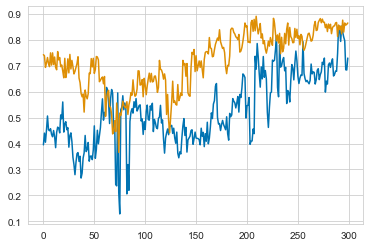

In [148]:
plt.plot(dqn.mean_rewards)
plt.plot(dqn_adversary.mean_rewards)

Не до конца понял, что не так. reward не забыл менять для dqn-антагониста. По разному пробовал. Не совсем понятно, почему против рандома у нее не получается лучше играть. На Rollouts с MCTS не хватило сил.